# RunAge WBDS UD ENEBI2020

> [Laboratory of Biomechanics and Motor Control](http://demotu.org/)  
> Federal University of ABC, Brazil

In [1]:
path2 = r'C:\Users\ebm\Desktop\Lucas Santana\RunAge\WBDStxt'
trial  = 'WBDS04walkO01'
condition = 'C'
mass   = 61.05
fplat = ['Fx2', 'Fy2', 'Fz2', 'COPx2', 'COPy2', 'COPz2', 'Ty2']

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
#%matplotlib notebook
#%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import sys, os
import csv
import math
from scipy.signal import butter, filtfilt
from scipy import signal, misc
from IPython.display import display, Math, Latex

#%load_ext autoreload
#%autoreload 2

sys.path.insert(1, r'./../functions')
import io_cortexmac as io
from dfmlevel import dfmlevel
from critic_damp import critic_damp
from detect_onset import detect_onset
from tnorm import tnorm
from resample import resample
from svdt import svdt
from derivative import derivative
from local_to_global import local_to_global
from global_to_local import global_to_local
from invdyn3d import invdyn3d
from ang_vel3d import ang_vel3d
from bsp import bsp

## Import static data

In [3]:
fname = os.path.join(path2, trial[:-7]+'static1.txt')
dfS = pd.read_csv(fname, sep='\t', header=0, index_col=0,skiprows=None, encoding='utf-8', engine='c')

ptS = dfS/1000
# foot markers
rhees = ptS[['R.HeelX', 'R.HeelY', 'R.HeelZ']].values
rmt1s = ptS[['R.MT1X', 'R.MT1Y', 'R.MT1Z']].values
rmt5s = ptS[['R.MT5X', 'R.MT5Y', 'R.MT5Z']].values
rmt2s = (rmt1s+rmt5s)/2
lhees = ptS[['L.HeelX', 'L.HeelY', 'L.HeelZ']].values
# shank markers
rhfis = ptS[['R.HFX', 'R.HFY', 'R.HFZ']].values
rttis = ptS[['R.TTX', 'R.TTY', 'R.TTZ']].values
rlmls = ptS[['R.AnkleX', 'R.AnkleY', 'R.AnkleZ']].values
rmmls = ptS[['R.Ankle.MedialX', 'R.Ankle.MedialY', 'R.Ankle.MedialZ']].values
rajcs = (rlmls+rmmls)/2

LMs = rlmls
MMs = rmmls
VMs = rmt5s
FMs = rmt1s
CAs = rhees
HFs = rhfis
TTs = rttis

## Import dynamic data

In [4]:
#freq = 1000
#dt = 1/freq
M = mass
gender = 'M'
g = 9.80665  # m/s2, standard acceleration of free fall (ISO 80000-3:2006)

fname2 = os.path.join(path2, trial+condition+'mkr.txt')
df = pd.read_csv(fname2, sep='\t', header=0, index_col=0,skiprows=None, encoding='utf-8', engine='c')

labels = ['R.HeelX', 'R.HeelY', 'R.HeelZ','R.MT1X', 'R.MT1Y', 'R.MT1Z', 
          'R.MT5X', 'R.MT5Y', 'R.MT5Z','R.HFX', 'R.HFY', 'R.HFZ',
         'R.TTX', 'R.TTY', 'R.TTZ','R.AnkleX', 'R.AnkleY', 'R.AnkleZ',
         'R.HeelX', 'R.HeelY', 'R.HeelZ','L.HeelX', 'L.HeelY', 'L.HeelZ']
pt = df/1000

# Import force data

In [5]:
# read column labels
nameWgrf = os.path.join(path2, trial+condition+'grf.txt')
dfGRF = pd.read_csv(nameWgrf, sep='\t', header='infer', skiprows=0, index_col=0, engine='c')

In [6]:
dfGRF = dfGRF[fplat]
an = dfGRF

In [7]:
# GRFs
Fgrf = an.values[:, 0:3]
# COP
cop_position = an.values[:, 3:6]/1000
# Free Moment
Mfree = np.atleast_2d(an.values[:, 6]).T
Mfree = Mfree/1000

## Resample data if necessary

In [8]:
nrows_pt, nrows_an = pt.shape[0], an.shape[0]

freq = 300
dt = 1/freq
an.index = an.index/freq
if nrows_pt != nrows_an:
    print(nrows_pt, nrows_an)
    if nrows_pt > nrows_an:
        print('an freq is lower than pt freq!')
    pt = resample(pt, freq_new=freq, freq_old=freq*nrows_pt/nrows_an, limit=1000)

405 810


## Filtering data

In [9]:
# Butterworth filter
b, a = butter(2, (10/(freq/2)))
for i in range(pt.shape[1]):
    # Deal if all values are NaNs
    if pt.iloc[:, i].isnull().all():
        pt.iloc[:, i] = 0
    # First deal with NaNs in the data
    pt.iloc[:, i], _, _ = tnorm(pt.iloc[:, i], step=0, k=1, smooth=0, nan_at_ext='replace')
    pt.iloc[:, i] = filtfilt(b, a, pt.iloc[:, i])     

# Filter forces
b, a, fc = critic_damp(fcut=50, freq=freq, npass=1, fcorr=False, filt='critic')
for i in range(Fgrf.shape[1]):
    Fgrf[:, i], _, _ = tnorm(Fgrf[:, i], step=0, k=1, smooth=0, nan_at_ext='replace')
    Fgrf[:, i] = filtfilt(b, a, Fgrf[:, i])
Fgrf[:, 1] = Fgrf[:, 1] - np.min(Fgrf[:, 1])

b, a, fc = critic_damp(fcut=20, freq=freq, npass=1, fcorr=False, filt='critic')
for i in range(cop_position.shape[1]):
    cop_position[:, i], _, _ = tnorm(cop_position[:, i], step=0, k=1, smooth=0, nan_at_ext='replace')
    cop_position[:, i] = filtfilt(b, a, cop_position[:, i])

b, a, fc = critic_damp(fcut=50, freq=freq, npass=1, fcorr=False, filt='critic')
for i in range(Mfree.shape[1]):
    Mfree[:, i], _, _ = tnorm(Mfree[:, i], step=0, k=1, smooth=0, nan_at_ext='replace')
    Mfree[:, i] = filtfilt(b, a, Mfree[:, i])     
    
Mfree = np.c_[np.zeros(Mfree.shape), Mfree, np.zeros(Mfree.shape)]

## Define markers name

In [10]:
# foot markers
rheew = pt[['R.HeelX', 'R.HeelY', 'R.HeelZ']].values
rmt1w = pt[['R.MT1X', 'R.MT1Y', 'R.MT1Z']].values
rmt5w = pt[['R.MT5X', 'R.MT5Y', 'R.MT5Z']].values
lheew = pt[['L.HeelX', 'L.HeelY', 'L.HeelZ']].values
# shank markers
rhfiw = pt[['R.HFX', 'R.HFY', 'R.HFZ']].values
rttiw = pt[['R.TTX', 'R.TTY', 'R.TTZ']].values
rlmlw = pt[['R.AnkleX', 'R.AnkleY', 'R.AnkleZ']].values


#rajcw = (rlmlw+rmmlw)/2
LM = rlmlw
VM = rmt5w
FM = rmt1w
CA = rheew
HF = rhfiw
TT = rttiw

## Create virtual markers

In [11]:
# Shank
shankMarkersstatic = ptS[['R.HFX', 'R.HFY', 'R.HFZ','R.TTX', 'R.TTY', 'R.TTZ',
                        'R.AnkleX', 'R.AnkleY', 'R.AnkleZ']].values
shankMarkersstatic = np.mean(shankMarkersstatic, axis=0)
shankMarkerswalk = pt[['R.HFX', 'R.HFY', 'R.HFZ','R.TTX', 'R.TTY', 'R.TTZ',
                        'R.AnkleX', 'R.AnkleY', 'R.AnkleZ']].values
# foot
footMarkersstatic = np.array([FMs, VMs, CAs])
footMarkersstatic = np.mean(footMarkersstatic, axis=1)
footMarkersstatic = np.reshape(footMarkersstatic,9)
footMarkerswalk = np.array([FM, VM, CA])
footMarkerswalk = np.reshape(footMarkerswalk,(footMarkerswalk.shape[1],9))

In [12]:
# Calculating the translation and rotation matrix
# from svdt import svdt
Rshank, Lshank, RMSE = svdt(shankMarkersstatic, shankMarkerswalk)
Rfoot, Lfoot, RMSE = svdt(footMarkersstatic, footMarkerswalk)

In [13]:
#rmt2w = np.dot(Rfoot,rmt2s) + Lfoot
MM = np.dot(Rshank,np.mean(MMs,axis=0)) + Lshank
rmt2w = (FM+VM)/2
rajcw = (MM+LM)/2

## Detect events

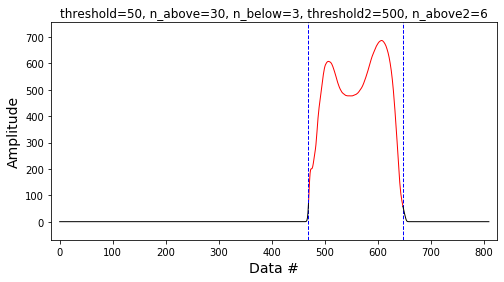

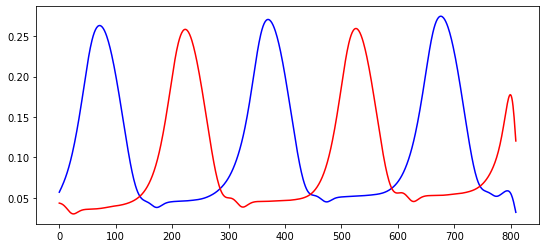

In [14]:
# detect onsets in Fy data
threshold = 50
n_above = int(0.1*freq)
n_below = int(0.01*freq)
threshold2 = 10*threshold  # N
n_above2 = int(0.02*freq)
idx = detect_onset(Fgrf[:, 1], threshold, n_above, n_below,
                   threshold2, n_above2, show=True)

R = pt[['R.HeelX', 'R.HeelY', 'R.HeelZ']].values[:, 1]
L = pt[['L.HeelX', 'L.HeelY', 'L.HeelZ']].values[:, 1]

if 1:
    plt.figure(figsize=(9, 4))
    plt.plot(R, 'b', L, 'r')
    plt.show()

# step side identification
idR = []
for ini, end in idx:
    if R[ini:int((ini + end)/2)].sum() < L[ini:int((ini + end)/2)].sum():
        idR = np.hstack((idR, [ini, end]))
idR = idR.reshape((-1, 2)).astype(int)

In [15]:
def footIOR(heel, mt1, mt2, mt5):
    """Calculates the foot coordinate system using the convention of IOR and CAST
    """
    # CAST and IOR shank
    yFoot=np.cross(mt5-heel, mt1-heel)
    zFoot=np.cross(mt2-heel, yFoot)
    xFoot=np.cross(yFoot, zFoot)
    # Normalizing
    xFoot=xFoot/np.linalg.norm(xFoot)
    yFoot=yFoot/np.linalg.norm(yFoot)
    zFoot=zFoot/np.linalg.norm(zFoot)

    footIOR = np.array([xFoot, yFoot, zFoot])

    return footIOR

def shankIOR(rhfi, rtti, rlml, rajc):
    """Calculates the shank coordinate system using the convention of IOR and CAST
    """
    # CAST and IOR shank
    xShank = np.cross(rhfi-rajc, rlml-rajc)
    zShank = np.cross(xShank, rtti-rajc)
    yShank = np.cross(zShank, xShank)
    # Normalizing
    xShank = xShank/np.linalg.norm(xShank)
    yShank = yShank/np.linalg.norm(yShank)
    zShank = zShank/np.linalg.norm(zShank)

    shankCAST = np.array([xShank, yShank, zShank])

    return shankCAST

shankCSwalk= np.empty(shape=(len(rheew),3,3))
footCSwalk = np.empty(shape=(len(rheew),3,3))
for ix in range(rheew.shape[0]):
    shankCSwalk[ix,:,:] = shankIOR(rhfiw[ix,:], rttiw[ix,:], rlmlw[ix,:], rajcw[ix,:])
    footCSwalk[ix,:,:]  = footIOR(rheew[ix,:], rmt1w[ix,:], rmt2w[ix,:], rmt5w[ix,:])
    
e3_foot = footCSwalk[:,2,:]
e2_foot = footCSwalk[:,1,:]
e1_foot = footCSwalk[:,0,:]

e3_shank = shankCSwalk[:,2,:]
e2_shank = shankCSwalk[:,1,:]
e1_shank = shankCSwalk[:,0,:]

# Angular acceleration
Os versores são extremamente importantes para o cálculo da aceleração angular dos segmentos. Para tal, todos foram derivados ("dedt_foot" e "dedt_shank") e em seguida multiplicados pelos valores dos outros segmentos, gerando desse modo a aceleração angular ("omega_foot" e "omega_shank")

In [16]:
omega_footFoot = ang_vel3d(e1_foot,e2_foot,e3_foot,dt)
omega_footGlobal = local_to_global(omega_footFoot,e1_foot,e2_foot,e3_foot)
    
omega_shankShank = ang_vel3d(e1_shank,e2_shank,e3_shank,dt)
omega_shankGlobal = local_to_global(omega_shankShank,e1_shank,e2_shank,e3_shank)

## Center of mass

In [17]:
a = HF - LM
b = LM - MM
n = np.cross(a, b, axis=1)
n_norm = n/np.linalg.norm(n, axis=1, keepdims=True)

Finding the distance between TT and the TTp:

In [18]:
d = np.sum((TT-LM)*n_norm,axis=1, keepdims=True)
TTp = TT - (d*n_norm)
# Testing (Must be zero):
Test = np.sum((HF - TTp)*n_norm, axis=1)
np.allclose(Test, 0)

True

Segments positions:

In [19]:
r_foot_prox  = CA
r_foot_dis   = (VM+FM)/2
r_shank_prox = TTp
r_shank_dis  = (MM+LM)/2

In [20]:
m_foot,I_foot, rcm_foot = bsp(M, 'M', 'Foot', r_foot_dis, r_foot_prox, show=True)
m_shank,I_shank, rcm_shank = bsp(M, 'M', 'Shank', r_shank_dis, r_shank_prox, show=True)

The velocity and acceleration of the center of mass of each segment:

In [21]:
vcm_foot  = (rcm_foot[2:,:] - rcm_foot[0:-2,:])/(2*dt)
vcm_foot  = np.vstack((vcm_foot, vcm_foot[-1, :], vcm_foot[-1, :]))
vcm_shank = (rcm_shank[2:,:] - rcm_shank[0:-2,:])/(2*dt)
vcm_shank = np.vstack((vcm_shank, vcm_shank[-1, :], vcm_shank[-1, :]))

acm_foot  = (vcm_foot[2:,:] - vcm_foot[0:-2,:])/(2*dt)
acm_foot  = np.vstack((acm_foot, acm_foot[-1, :], acm_foot[-1, :]))
acm_shank = (vcm_shank[2:,:] - vcm_shank[0:-2,:])/(2*dt)
acm_shank = np.vstack((acm_shank, acm_shank[-1, :], acm_shank[-1, :]))

## Displacement of the COP with respect to the UD segment’s COM

Para calcular a potência pelo método proposto por Takahashi et al., foi necessário obter a distância do centro de pressão até o centro de massa da componente rígida, que no caso é o segmento perna.

In [22]:
rUD_cop_aux = cop_position - rcm_shank
rUD_cop = rUD_cop_aux[0:len(omega_shankGlobal)]   

## Total deformation velocity of the distal component

Como a potência é o produto da força pela velocidade (ou torque pela velocidade angular), foi obtida a velocidade de translação do segmento UD, que utiliza o centro de massa da perna, sua velocidade angular e a distância entre o centro de pressão e o centro de massa da perna.

In [23]:
VUDd = vcm_shank + np.cross(omega_shankGlobal, rUD_cop)

## Total distal power of the UD segment

A potência total do segmento UD é a soma da "potência de trsnalação" com  a "potência de rotação", onde ess última utiliza o momento livre e a velocidade angular da perna

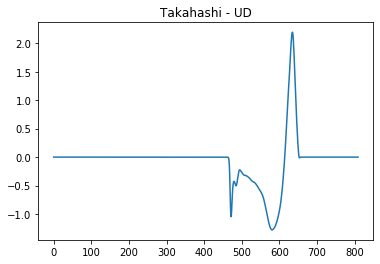

In [24]:
#Mfree = Mfree[:,3:6]
aux4 = np.sum(Fgrf[0:len(VUDd)]*VUDd, axis=1)
aux5 = np.sum(Mfree[0:len(omega_shankGlobal)]*omega_shankGlobal, axis=1)
PUD = aux4 + aux5

aux4 = np.sum(Fgrf[0:len(VUDd)]*VUDd, axis=1)
aux5 = np.sum(Mfree[0:len(omega_shankGlobal)]*omega_shankGlobal, axis=1)
PUD = aux4 + aux5

if 1:
    plt.figure()
    plt.title('Takahashi - UD')
    plt.plot(PUD/M)
    plt.show()

## Inverse dynamics

#### Segments angular acceleration

As velocidades angulares e cada segmento obtidas anteriormente foram derivadas para se obter as acelerações angulares

In [25]:
alpha_footGlobal  = derivative(omega_footGlobal,dt) #Global
alpha_footGlobal  = np.vstack((alpha_footGlobal, alpha_footGlobal[-1, :], alpha_footGlobal[-1, :]))
alpha_shankGlobal = derivative(omega_shankGlobal,dt) #Global
alpha_shankGlobal = np.vstack((alpha_shankGlobal, alpha_shankGlobal[-1, :], alpha_shankGlobal[-1, :]))

### Forces

Iniciando do segmento pé, foi realizado a soma das forças em ambos os segmentos. As forças provenientes de outro segmento foram adotadas como tendo sinal negativo, comopode ser visualizado nas equaqções de força para a perna, onde "F_ankle" teve o final negativo.

##### Foot

In [26]:
Fp_ankle, Mp_ankle = invdyn3d(rcm_foot, cop_position, r_shank_dis, acm_foot, alpha_footGlobal, omega_footGlobal,m_foot, I_foot, Fgrf, Mfree, e1_foot, e2_foot, e3_foot)

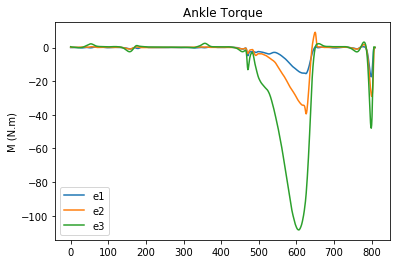

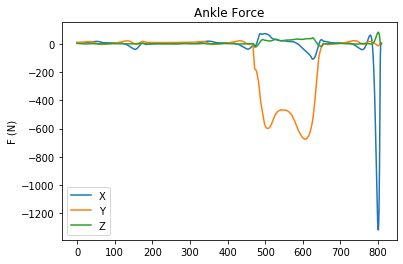

In [27]:
if 1:
    plt.figure()
    plt.plot(Mp_ankle)
    plt.legend(('e1','e2','e3'))
    plt.title('Ankle Torque')
    plt.ylabel('M (N.m)')
    plt.show()
    
    plt.figure()
    plt.plot(Fp_ankle)
    plt.title('Ankle Force')
    plt.legend(('X','Y','Z'))
    plt.ylabel('F (N)')
    plt.show()

##### Shank

##### Segments angular acceleration

In [28]:
#Foot
alpha_footFoot = global_to_local(alpha_footGlobal,e1_foot,e2_foot,e3_foot) 
#Shank
alpha_shankShank = global_to_local(alpha_shankGlobal,e1_shank,e2_shank,e3_shank)
#Free Moment
MfreeFoot = global_to_local(Mfree,e1_foot,e2_foot,e3_foot)
#Moment
Mp_ankleGlobal = local_to_global(Mp_ankle, e1_foot, e2_foot, e3_foot)
Mp_ankleShank = global_to_local(Mp_ankleGlobal, e1_shank, e2_shank, e3_shank)

##### Moment and force

In [29]:
Fp_knee, Mp_knee = invdyn3d(rcm_shank, r_shank_dis, r_shank_prox, acm_shank, alpha_shankGlobal, omega_shankGlobal,m_shank, I_shank, -Fp_ankle, -Mp_ankleShank, e1_shank, e2_shank, e3_shank)

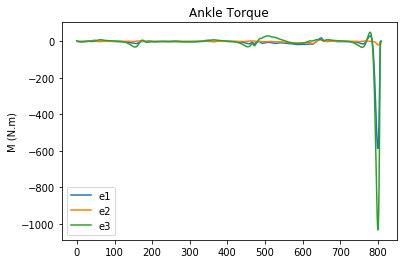

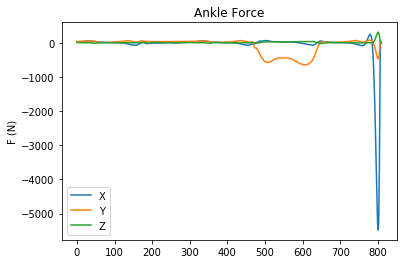

In [30]:
if 1:
    plt.figure()
    plt.plot(Mp_knee)
    plt.legend(('e1','e2','e3'))
    plt.title('Ankle Torque')
    plt.ylabel('M (N.m)')
    plt.show()
    
    plt.figure()
    plt.plot(Fp_knee)
    plt.title('Ankle Force')
    plt.legend(('X','Y','Z'))
    plt.ylabel('F (N)')
    plt.show()

## Anatomically-relevant (AR) Power

A forma mais completa de se obter a potência por meio da dinâmica inversa é pela soma da potência do tornozelo obtida com um modelo de 6 graus de liberdade com a potência no pé.

#### Angular Velocity

Para obter a velocidade angular no tornozelo, foi feita a subtração da velocidade angular no pé pela velocidade angular na perna

In [31]:
omega_ankleGlobal = omega_footGlobal - omega_shankGlobal

#### Joint Velocity

Com a velocidade de rotação obtida, no passo seguinte foi feita a equação para obter a velocidade de translação no tornozelo. Para tal, foram calculadas as velocidades no tornozelo referentes a cada um dos segmentos. Em seguida, ambas as velocidade foram subtraídas para obter a velocidade na articulação do tornozelo.

In [32]:
VcopGlobal = vcm_foot + np.cross(omega_footGlobal, cop_position[0:len(omega_footGlobal)] - rcm_foot[0:len(omega_footGlobal)])
VanklefootGlobal = vcm_foot + np.cross(omega_footGlobal, r_shank_dis[0:len(omega_footGlobal)] - rcm_foot[0:len(omega_footGlobal)])
VankleshankGlobal = vcm_shank + np.cross(omega_shankGlobal, r_shank_dis[0:len(omega_shankGlobal)] - rcm_shank[0:len(omega_shankGlobal)])
deltaVGlobal = VanklefootGlobal - VankleshankGlobal

#### Power (Pank)

A potência no tornozelo foi obtida utilizando os modelo de 6 graus de liberdade para os cálculos, somando a potência de translação com a potência de rotação

In [33]:
Pank = np.sum(Mp_ankle[0:len(Fgrf)]*omega_ankleGlobal[0:len(Fgrf)], axis=1) + \
       np.sum(Fp_ankle[0:len(Fgrf)]*deltaVGlobal[0:len(Fgrf)], axis=1)

p1 = np.sum(Mp_ankle[0:len(Fgrf)]*omega_ankleGlobal[0:len(Fgrf)], axis=1)
p2 = np.sum(Fp_ankle[0:len(Fgrf)]*deltaVGlobal[0:len(Fgrf)], axis=1)

if 0:
    plt.figure()
    plt.plot(p1/M)
    plt.plot(p2/M)
    plt.legend(('$P Rotação$','$P Traslação$'))
    plt.title(('Power'))
    plt.show()
    plt.grid()

#### Power (Pftd)

A potência no pé foi obtida pela soma dos produtos entre a forla de reação do solo com a velocidade do centro de pressão com o produto do momento livre com a velocidade angular.

In [34]:
Pftd = np.sum(Fgrf*VcopGlobal[0:len(Fgrf)], axis=1) + \
       np.sum(Mfree[0:len(Fgrf)]*omega_footGlobal[0:len(Fgrf)], axis=1)

#### Power (PAR)

Ambas as potências obtidas anteriormente foram somadas para se obter a potência total

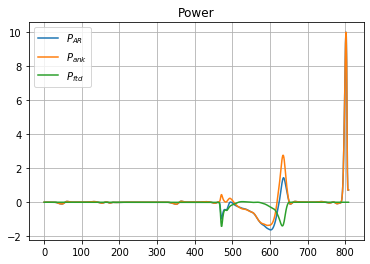

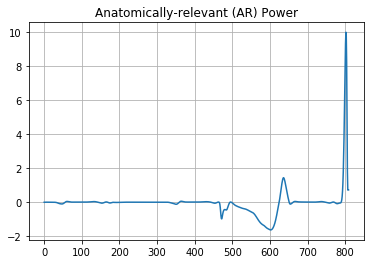

In [35]:
Pank = Pank/M
Pftd = Pftd/M
Par = Pank + Pftd

if 1:
    plt.figure()
    plt.plot(Par)
    plt.plot(Pank)
    plt.plot(Pftd)
    plt.legend(('$P_{AR}$','$P_{ank}$','$P_{ftd}$'))
    plt.title(('Power'))
    #plt.show()
    plt.grid()

if 1:
    plt.figure()
    plt.plot(Par)
    plt.title(('Anatomically-relevant (AR) Power'))
    #plt.show()
    plt.grid()

## Trimm data

In [36]:
Par2 = np.empty((101,int(idR.shape[0])))
Pank2= np.empty((101, int(idR.shape[0]))) 
Pftd2= np.empty((101, int(idR.shape[0])))
Tank2= np.empty((101, int(idR.shape[0])))
i = 0
for ini, fim in idR:
    if not np.any(np.isnan(Par[ini:fim])):
        ParX = Par[ini:fim]
        PankX= Pank[ini:fim]
        PftdX= Pftd[ini:fim]
        TankX= Mp_ankle[ini:fim,2]

        yn1, tn, indie = tnorm(ParX, k=1, smooth=0, mask=None, show=False)
        yn2, tn, indie = tnorm(PankX, k=1, smooth=0, mask=None, show=False)
        yn3, tn, indie = tnorm(PftdX, k=1, smooth=0, mask=None, show=False)
        yn4, tn, indie = tnorm(TankX, k=1, smooth=0, mask=None, show=False)

        Par2[:, i]  = yn1
        Pank2[:,i] = yn2
        Pftd2[:,i] = yn3
        Tank2[:,i] = yn4
        i += 1
        
Par2 = Par2[:, 0:i]
Pank2 = Pank2[:, 0:i]
Pftd2 = Pftd2[:, 0:i]
Tank2 = Tank2[:, 0:i]

## Save Powers

C:\Users\ebm\Miniconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\ebm\Miniconda3\lib\site-packages\numpy\core\_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


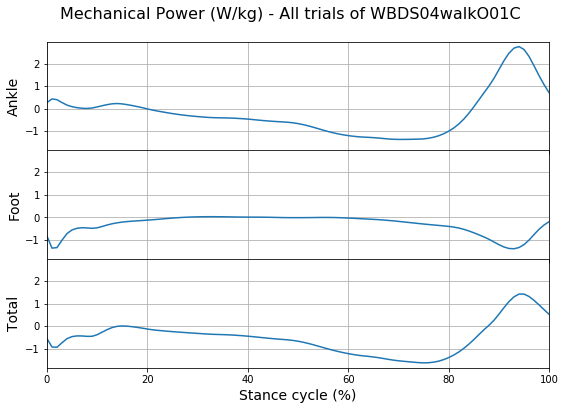

In [37]:
powers = np.c_[tn, np.mean(Par2, 1), np.std(Par2, 1, ddof=1),
               np.mean(Pank2, 1), np.std(Pank2, 1, ddof=1),
               np.mean(Pftd2, 1), np.std(Pftd2, 1, ddof=1)]

fname_pwr = os.path.join(path2, trial + '_' + condition + '_pwr.txt')
# header and format for file
fmt = '%.d' + '\t%.6f'*(powers.shape[1]-1)
header = 'Time\tPar_m\tPar_sd\tPank_m\tPank_sd\tPftd_m\tPftd_sd'
# save sensors data
#np.savetxt(fname=fname_pwr, X=powers, fmt=fmt, delimiter='\t', header=header, comments='')

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(9, 6), 
                        gridspec_kw={'hspace': 0})
plt.suptitle('Mechanical Power (W/kg) - All trials of {}'.format(trial+condition), y=.96, fontsize=16)
axs[0].plot(tn, Pank2)
axs[0].set_xlim([0, 100])
axs[1].plot(tn, Pftd2)
axs[2].plot(tn, Par2)
plt.xlabel('Stance cycle (%)', fontsize=14)
labels = ['Ankle', 'Foot', 'Total']
for ax, label in zip(axs, labels):
    ax.grid()
    ax.label_outer()
    ax.set_ylabel(label, fontsize=14)